# Arbaro demo scene

Notebook: Hannah Weiser, 2025

This demo showcases two highly detailed tree models scanned from two terrestrial laser scanning (TLS) scanning positions.

In [1]:
import helios
from helios.settings import OutputFormat, LogVerbosity # these should not have to be imported extra?
import numpy as np

## Creating the virtual scene

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(100)  # scale groundplane by 100
tree1 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/black_tupelo_low.obj", up_axis="y")  # 3D models exported from Blender often have the Y-axis as "up-axis"
tree2 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/sassafras_low.obj", up_axis="y")
# Trees should both be scaled down by half and translated
tree1 = tree1.scale(0.5).translate([0.0, 15.0, 0.0])
tree2 = tree2.scale(0.5).translate([-10.0, 15.0, 0.0])
#create scene
scene = helios.StaticScene(scene_parts=[groundplane, tree1, tree2])

## Platform and Scanner

In [3]:
from helios.scanner import riegl_vz_400
from helios.platforms import tripod

scanner = riegl_vz_400()
platform = tripod()

## Scanner Settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                          scan_frequency=120,  # Hz
                                          min_vertical_angle=-40 * helios.units.deg,  # °
                                          max_vertical_angle=60 * helios.units.deg,
                                          head_rotation="10 deg/s"
                                         )
# for rotating head and rotating mirror terrestrial laser scanners, we can also provide 
# the vertical and horizontal angular resolution instead of scan frequency and head rotation speed
scanner_settings2 = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                           vertical_resolution=0.2,# * helios.units.deg,
                                           horizontal_resolution=0.2,# * helios.units.deg,
                                           min_vertical_angle=-40 * helios.units.deg,
                                           max_vertical_angle=60 * helios.units.deg
                                          )

fullwave_settings = helios.FullWaveformSettings(
    bin_size=0.2 * helios.units.ns,
    beam_sample_quality=3  # default
)

## Scan Positions

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
# first scan position
survey.add_leg(scanner_settings=scanner_settings,
               x=1.0,
               y=25.5,
               z=1.5,
               force_on_ground=True,  # this works because of the specification in the groundplane.mtl file
               rotation_start_angle=100 * helios.units.deg,
               rotation_stop_angle=225 * helios.units.deg
              )
# second scan position, here we use the other scan setting definition
survey.add_leg(scanner_settings=scanner_settings,  # scanner_settings2 is not working..
               x=-4.0,
               y=-2.5,
               z=1.5,
               force_on_ground=True,
               rotation_start_angle=-45 * helios.units.deg,
               rotation_stop_angle=45 * helios.units.deg
              )

## Executing the survey

In [6]:
points, trajectories = survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.NPY)

`points` and `trajectories` are numpy arrays of structured data type:

In [7]:
points[:3]

array([(0, 0, [-7.75326797e+00,  2.39445093e+01,  3.46431346e-03], [-0.92650733, -0.16464405, -0.33834378], [ 1.       , 25.5      , -3.7726975],  9.44759715, 3167609.35520265, 0., 1, 1, 70, 0, 250535.00764),
       (0, 0, [-1.38070646e+01,  2.28680057e+01,  3.32628363e-03], [-0.96305163, -0.17118494, -0.20791169], [ 1.       , 25.5      , -3.7726975], 15.37515136,  905254.40947312, 0., 1, 1, 97, 0, 250535.00791),
       (0, 0, [-7.89803307e+00,  2.39187680e+01,  1.80531929e-03], [-0.92816979, -0.16494115, -0.33360943], [ 1.       , 25.5      , -3.7726975],  9.58664365, 3325874.54706395, 0., 1, 1, 71, 0, 250535.00765)],
      dtype=[('channel_id', '<u8'), ('hit_object_id', '<i4'), ('position', '<f8', (3,)), ('beam_direction', '<f8', (3,)), ('beam_origin', '<f8', (3,)), ('distance', '<f8'), ('intensity', '<f8'), ('echo_width', '<f8'), ('return_number', '<i4'), ('number_of_returns', '<i4'), ('fullwave_index', '<i4'), ('classification', '<i4'), ('gps_time', '<f8')])

In [8]:
trajectories[:3]

array([(250535.  , [ 1. , 25.5,  1.5], -0., 0., -0.),
       (250535.01, [ 1. , 25.5,  1.5], -0., 0., -0.),
       (250535.02, [ 1. , 25.5,  1.5], -0., 0., -0.)],
      dtype=[('gps_time', '<f8'), ('position', '<f8', (3,)), ('roll', '<f8'), ('pitch', '<f8'), ('yaw', '<f8')])

There are also different output formats besides numpy arrays. If we rather want to write the point clouds to file, we could also specify `OutputFormat.LAZ` which will write compressed LAS (i.e., LAZ) files, the community standard file format for LiDAR point clouds. We can also set different log verbosity levels.

In [9]:
survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.LAZ)

WindowsPath('D:/Software/_helios_versions/helios_dev/example_notebooks/output/2025-10-28_22-35-49')

## Visualizing the result

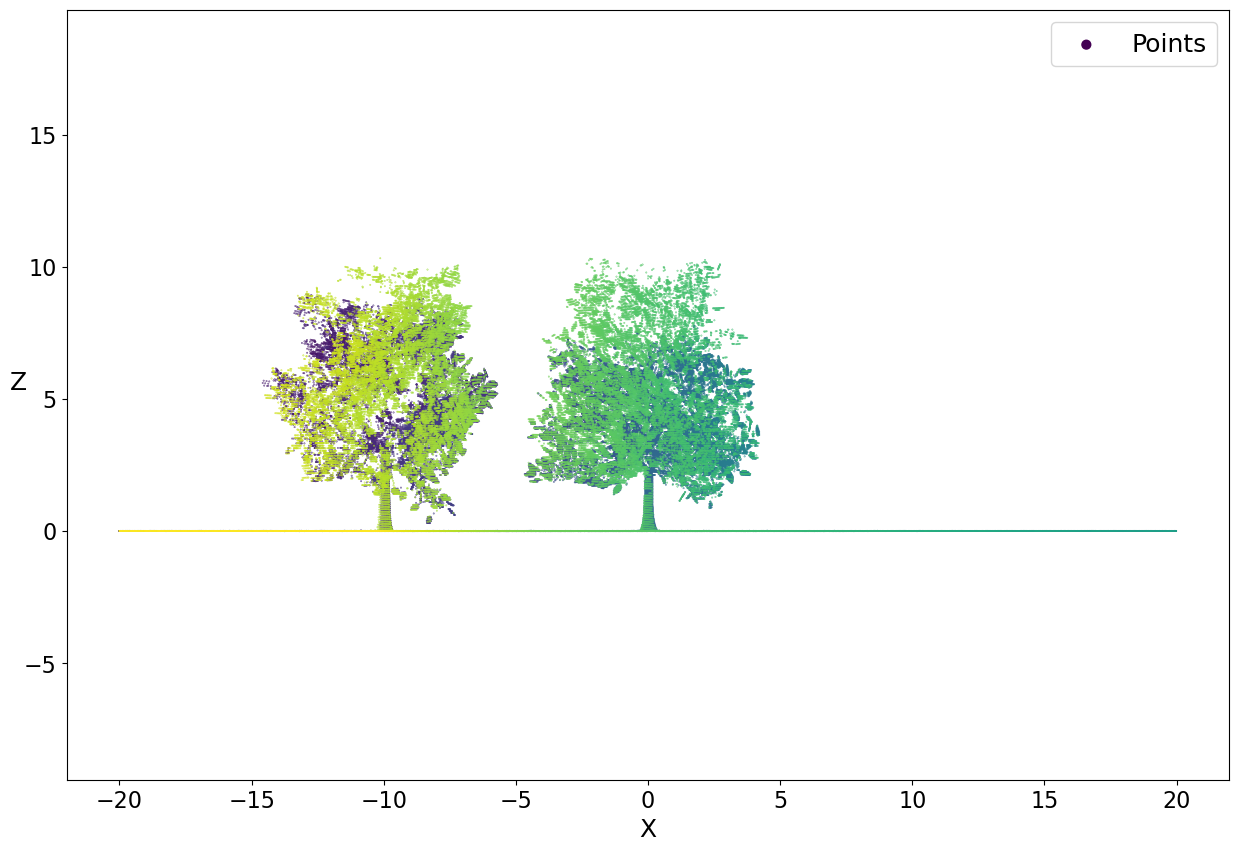

In [10]:
import matplotlib.pyplot as plt

pos = points["position"]

# discard points outside of [-20, -20] to [20, 20] (x, y)
points_sub = points[
    (pos[:, 0] > -20) & (pos[:, 1] > -20) & (pos[:, 0] < 20) & (pos[:, 1] < 20)
]
pos = points_sub["position"]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(
   pos[:, 0], pos[:, 2], s=0.1, label="Points", c=points_sub["gps_time"]
)
plt.axis("equal")
ax.tick_params(labelsize=16)
plt.xlabel("X", fontsize=18)
plt.ylabel("Z", fontsize=18, rotation=0)
plt.legend(fontsize=18, markerscale=20)
plt.show()